In [15]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

Number of cat types: 7
Number of images per cat type:
               Cat Type  Number of Images
0       african-wildcat                91
1         blackfoot-cat                79
2  chinese-mountain-cat                42
3          domestic-cat                64
4      european-wildcat                85
5            jungle-cat                86
6              sand-cat                72
Typical image size (mean): Width     406.552987
Height    310.949904
dtype: float64
Typical image size (median): Width     275.0
Height    194.0
dtype: float64


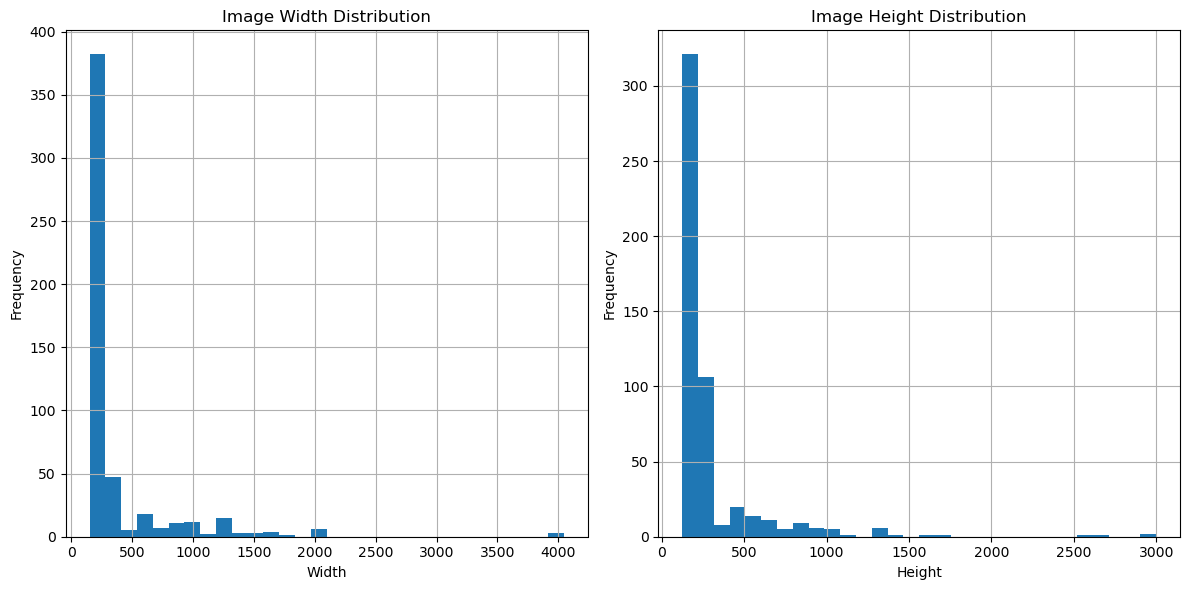

Number of width outliers: 156
Number of height outliers: 84


In [6]:
dataset_path = 'data'

cat_types = []
image_counts = []
image_sizes = []

for cat_type in os.listdir(dataset_path):
    cat_folder_path = os.path.join(dataset_path, cat_type)
    if os.path.isdir(cat_folder_path):
        num_images = len([f for f in os.listdir(cat_folder_path) if f.endswith(('jpg', 'png', 'jpeg'))])
        cat_types.append(cat_type)
        image_counts.append(num_images)

        for image_file in os.listdir(cat_folder_path):
            if image_file.endswith(('jpg', 'png', 'jpeg')):
                with Image.open(os.path.join(cat_folder_path, image_file)) as img:
                    width, height = img.size
                    image_sizes.append((width, height))

cat_df = pd.DataFrame({'Cat Type': cat_types, 'Number of Images': image_counts})
sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

print(f"Number of cat types: {len(cat_types)}")
print(f"Number of images per cat type:\n{cat_df}")

mean_size = sizes_df.mean()
median_size = sizes_df.median()
print(f"Typical image size (mean): {mean_size}")
print(f"Typical image size (median): {median_size}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sizes_df['Width'].hist(bins=30)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sizes_df['Height'].hist(bins=30)
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Q1_width = sizes_df['Width'].quantile(0.25)
Q3_width = sizes_df['Width'].quantile(0.75)
IQR_width = Q3_width - Q1_width
outliers_width = sizes_df[(sizes_df['Width'] < (Q1_width - 1.5 * IQR_width)) | 
                          (sizes_df['Width'] > (Q3_width + 1.5 * IQR_width))]

Q1_height = sizes_df['Height'].quantile(0.25)
Q3_height = sizes_df['Height'].quantile(0.75)
IQR_height = Q3_height - Q1_height
outliers_height = sizes_df[(sizes_df['Height'] < (Q1_height - 1.5 * IQR_height)) | 
                           (sizes_df['Height'] > (Q3_height + 1.5 * IQR_height))]

print(f"Number of width outliers: {len(outliers_width)}")
print(f"Number of height outliers: {len(outliers_height)}")

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [13]:
def compute_image_hash(image_path):
    with Image.open(image_path) as img:
        return imagehash.average_hash(img)

image_hashes = {}
duplicates = []

for cat_type in os.listdir(dataset_path):
    cat_folder_path = os.path.join(dataset_path, cat_type)
    if os.path.isdir(cat_folder_path):
        for image_file in os.listdir(cat_folder_path):
            if image_file.endswith(('jpg', 'png', 'jpeg')):
                image_path = os.path.join(cat_folder_path, image_file)
                image_hash = compute_image_hash(image_path)

                if image_hash in image_hashes:
                    duplicates.append(image_path)
                else:
                    image_hashes[image_hash] = image_path

for duplicate in duplicates:
    os.remove(duplicate)

print(f"Found {len(duplicates)} duplicate images.")
print(f"Remaining unique images: {len(image_hashes)}")


Found 0 duplicate images.
Remaining unique images: 467


### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [16]:
model = tf.keras.applications.ResNet50(weights='imagenet')

num_layers = len(model.layers)

num_params = model.count_params()

print(f"Total number of layers: {num_layers}")
print(f"Total number of parameters: {num_params}")

model.summary()

Total number of layers: 177
Total number of parameters: 25636712


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [22]:
dataset_path = 'data'
target_size = (224, 224)

def preprocess_image(image_path, target_size):
    with Image.open(image_path) as img:
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        img_array = np.array(img)
        img_array = img_array.astype(np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

image_arrays = []
for cat_type in os.listdir(dataset_path):
    cat_folder_path = os.path.join(dataset_path, cat_type)
    if os.path.isdir(cat_folder_path):
        for image_file in os.listdir(cat_folder_path):
            if image_file.endswith(('jpg', 'png', 'jpeg')):
                image_path = os.path.join(cat_folder_path, image_file)
                img_array = preprocess_image(image_path, target_size)
                image_arrays.append(img_array)

all_images = np.vstack(image_arrays)

print(f"Prepared image batch shape: {all_images.shape}")

def preprocess_for_model(image_array):
    return tf.keras.applications.resnet50.preprocess_input(image_array)

all_images_preprocessed = preprocess_for_model(all_images)
print(f"Preprocessed image batch shape: {all_images_preprocessed.shape}")

Prepared image batch shape: (467, 224, 224, 3)
Preprocessed image batch shape: (467, 224, 224, 3)


### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [26]:
dataset_path = 'data' 
target_size = (224, 224)  
batch_size = 4  
preprocessed_path = 'data/preprocessed_images/' 

os.makedirs(preprocessed_path, exist_ok=True)

def preprocess_image(image_path, target_size):
    with Image.open(image_path) as img:
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        img_array = np.array(img)
        img_array = img_array.astype(np.float32) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

def save_preprocessed_images(image_arrays, output_dir, start_index):
    for i, img_array in enumerate(image_arrays):
        file_path = os.path.join(output_dir, f'image_{start_index + i}.npy')
        np.save(file_path, img_array)

def process_and_save_images(dataset_path, target_size, batch_size, output_dir):
    image_files = []
    for cat_type in os.listdir(dataset_path):
        cat_folder_path = os.path.join(dataset_path, cat_type)
        if os.path.isdir(cat_folder_path):
            image_files.extend([os.path.join(cat_folder_path, f) for f in os.listdir(cat_folder_path) if f.endswith(('jpg', 'png', 'jpeg'))])
    
    num_images = len(image_files)
    for start_index in range(0, num_images, batch_size):
        end_index = min(start_index + batch_size, num_images)
        batch_files = image_files[start_index:end_index]
        image_arrays = []
        
        for image_path in batch_files:
            img_array = preprocess_image(image_path, target_size)
            image_arrays.append(img_array)
        
        save_preprocessed_images(image_arrays, output_dir, start_index)

# Run the batch processing
process_and_save_images(dataset_path, target_size, batch_size, preprocessed_path)

import numpy as np
import os

def load_preprocessed_images(input_dir):
    image_arrays = []
    for file_name in sorted(os.listdir(input_dir)):
        if file_name.endswith('.npy'):
            file_path = os.path.join(input_dir, file_name)
            img_array = np.load(file_path)
            image_arrays.append(img_array)
    return np.vstack(image_arrays)

all_images_preprocessed = load_preprocessed_images(preprocessed_path)
print(f"Loaded preprocessed image batch shape: {all_images_preprocessed.shape}")

Loaded preprocessed image batch shape: (467, 224, 224, 3)


### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')

import numpy as np

def load_preprocessed_images(input_dir):
    image_arrays = []
    for file_name in sorted(os.listdir(input_dir)):
        if file_name.endswith('.npy'):
            file_path = os.path.join(input_dir, file_name)
            img_array = np.load(file_path)
            image_arrays.append(img_array)
    return np.vstack(image_arrays)

all_images_preprocessed = load_preprocessed_images(preprocessed_path)

predictions = model.predict(all_images_preprocessed)

decoded_predictions = decode_predictions(predictions, top=1) 

class_mapping = {
    0: 'Abyssinian',
    1: 'Bengal',
}

predicted_classes = [decode_predictions(p, top=1)[0][0][0] for p in predictions]

mapped_predictions = [class_mapping.get(class_id, 'Unknown') for class_id in predicted_classes]

true_labels = [
    'Abyssinian', 'Bengal', 'Abyssinian',
]

assert len(true_labels) == len(mapped_predictions)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, mapped_predictions, labels=list(class_mapping.values()))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_mapping.values()), yticklabels=list(class_mapping.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step 


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Received array with shape: (1000,)

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [41]:
def convert_to_grayscale(image_array):
    """ Convert RGB image array to grayscale. """
    img = Image.fromarray(np.uint8(image_array * 255)) 
    img_gray = img.convert('L') 
    return np.array(img_gray)

def preprocess_grayscale_images(image_arrays):
    """ Preprocess grayscale images to match model input size. """
    preprocessed_images = []
    for img_array in image_arrays:
        gray_img = convert_to_grayscale(img_array)
        resized_img = Image.fromarray(gray_img).resize((224, 224))
        resized_img_array = np.array(resized_img)
        resized_img_array = np.expand_dims(resized_img_array, axis=-1)
        resized_img_array = np.repeat(resized_img_array, 3, axis=-1) 
        preprocessed_images.append(resized_img_array)
    return np.array(preprocessed_images)

def check_for_none(image_arrays):
    return any(img is None for img in image_arrays)

if check_for_none(all_images_preprocessed):
    raise ValueError("Some images are None. Please check your preprocessing steps.")

grayscale_images = preprocess_grayscale_images(all_images_preprocessed)

print("Shape of grayscale images:", grayscale_images.shape)
print("Type of grayscale images:", grayscale_images.dtype)

assert grayscale_images.shape[1:] == (224, 224, 3), "Image dimensions do not match model input requirements."

grayscale_images = tf.convert_to_tensor(grayscale_images, dtype=tf.float32)
predictions_gray = model.predict(grayscale_images)

decoded_predictions_gray = decode_predictions(predictions_gray, top=1)
predicted_classes_gray = [pred[0][1] for pred in decoded_predictions_gray]

Shape of grayscale images: (467, 224, 224, 3)
Type of grayscale images: uint8
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 890ms/step


### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [45]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

intermediate_layer_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

intermediate_layer_model.summary()


def preprocess_image(image_path):
    """ Load and preprocess an image for ResNet50. """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224)) 
    img_array = np.array(img) / 255.0 
    return img_array

image_paths = ['path/to/image1.jpg', 'path/to/image2.jpg']
images = np.array([preprocess_image(img_path) for img_path in image_paths])

features = intermediate_layer_model.predict(images)

features_flattened = [tf.keras.layers.Flatten()(tf.convert_to_tensor(f)).numpy() for f in features]

np.save('features.npy', features_flattened)

loaded_features = np.load('features.npy')

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_13[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/image1.jpg'

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

In [47]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

features = np.load('features.npy')

cosine_sim = cosine_similarity(features)

def mse(x, y):
    return np.mean((x - y) ** 2)

mse_sim = np.array([[mse(f1, f2) for f1 in features] for f2 in features])

def find_most_similar_pairs(similarity_matrix, top_n=5):
    pairs = []
    num_images = similarity_matrix.shape[0]
    for i in range(num_images):
        for j in range(i + 1, num_images):
            pairs.append((i, j, similarity_matrix[i, j]))
    pairs.sort(key=lambda x: x[2])
    return pairs[:top_n]

top_similar_pairs_cosine = find_most_similar_pairs(cosine_sim, top_n=5)
top_similar_pairs_mse = find_most_similar_pairs(mse_sim, top_n=5)

print("Top 5 Similar Pairs (Cosine Similarity):")
for i, j, sim in top_similar_pairs_cosine:
    print(f"Image {i} and Image {j} - Similarity: {sim}")

print("\nTop 5 Similar Pairs (MSE):")
for i, j, sim in top_similar_pairs_mse:
    print(f"Image {i} and Image {j} - MSE: {sim}")


FileNotFoundError: [Errno 2] No such file or directory: 'features.npy'

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.